# Train a Simple TensorFlow Lite for Microcontrollers model (Preview)


## Introduction to the Jupyter Notebook

This Jupyter Notebook is inspired by the **Hello World Example** from the official LiteRT documentation for microcontrollers, which demonstrates how to train and deploy a model to predict the sine of a given input value [LiteRT Documentation](https://ai.google.dev/edge/litert/microcontrollers/get_started). The models trained here will be deployed directly to the model layer of this project.

#### Project Overview

The complete project is a hardware-agnostic [CMSIS Reference Application](https://github.com/Open-CMSIS-Pack/cmsis-toolbox/blob/main/docs/ReferenceApplications.md), designed to be compatible with any target hardware that supports the STDIO feature. This flexibility allows users to adapt the application to various devices without significant modifications.

#### Deep Learning and Sine Function Modeling

Deep learning networks are powerful tools for modeling patterns in data. In this notebook, we focus on training a network to model data generated by a **sine function**. The goal is to create a model that can take an input value `x` and predict its sine, `y`. This process involves training the model using a dataset of sine values and then deploying it for inference.

#### Training Process

The training process for the official model is outlined in the **`train.py`** script, which is part of the TensorFlow Lite Micro examples. This notebook picks up parts of it to train two models in a step by step approach.

#### Notebook Structure

This notebook will guide you through the following steps:

**Data Generation**: Creating a dataset of sine values.

**Model Training**: Training a neural network to predict sine values.

**Model Deployment**: Deploying the trained model to the project's model layer.

By following these steps, you will learn how to develop and deploy a simple deep learning model using LiteRT for microcontrollers.


### Install Python Packages required

Run pip to install Tensorflow etc. into the current environment.

In [7]:
#Tested on Python 3.9.13
import sys
!{sys.executable} -m pip install -r requirements.txt

'c:\Program'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### Configure Defaults
Configure pathes and filenames for generated files.

In [8]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_KERAS = MODELS_DIR + 'model.keras'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_float.tflite'
MODEL_INT8_QUANT_TFLITE = MODELS_DIR + 'model_int8.tflite'
MODEL_NO_QUANT_C = MODELS_DIR + 'model_float.c'
MODEL_INT8_QUANT_C = MODELS_DIR + 'model_int8.c'

### Check Environment

This script prints out key information about the environment, including:

- **Python Platform**: The underlying platform (e.g., Windows, Linux).
- **Python Version**: The version of Python being used.
- **TensorFlow, Keras, and Pandas Versions**: The versions of these libraries installed.
- **GPU Availability**: Whether a GPU is available for use with TensorFlow.

In [9]:
import sys
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import keras
import pandas as pd
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.26100-SP0
Tensor Flow Version: 2.19.0
Keras Version: 3.10.0

Python 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Pandas 2.3.0+4.g1dfc98e16a
GPU is NOT AVAILABLE


### Import Additional Dependencies

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

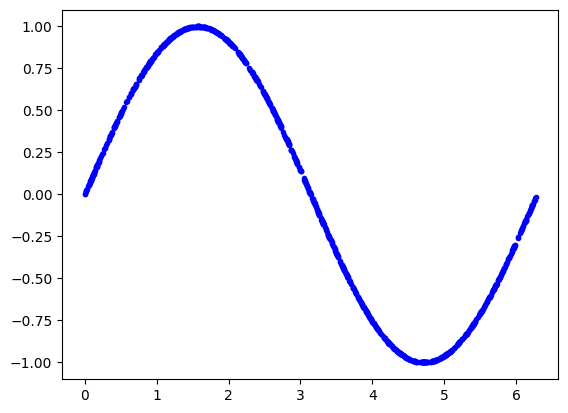

In [11]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

x_values.shape, x_values.min(), x_values.max()
x_values[:10]

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

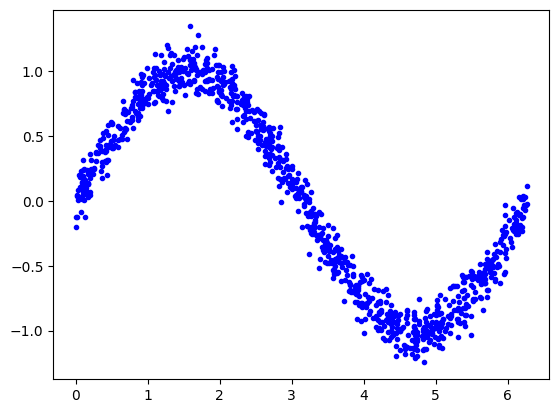

In [12]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20%

The following code will split our data and then plots each set as a different color:


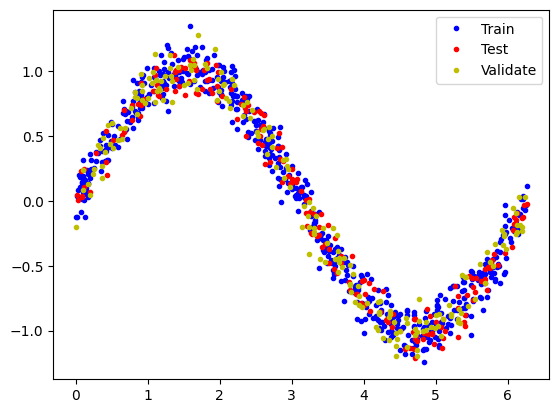

In [13]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
TRAIN_SPLIT, TEST_SPLIT


# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES
x_train.shape, x_test.shape, x_validate.shape


# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training a Simple Model

### Design the Model
We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 8 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [14]:
# Create model with proper input definition
model_small = keras.Sequential([
    keras.layers.Input(shape=(1,)),             # Explicit input layer for scalar input
    keras.layers.Dense(8, activation='relu'),    # Hidden layer with 8 neurons and ReLU
    keras.layers.Dense(1)                        # Output layer with single neuron
])

# Compile model with same optimization settings
model_small.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model architecture
model_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:



In [15]:
# Train the model on our training data while validating on our validation set
history_small = model_small.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5550 - mae: 1.1494 - val_loss: 1.2709 - val_mae: 1.0290
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2215 - mae: 1.0013 - val_loss: 0.9911 - val_mae: 0.8839
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9522 - mae: 0.8591 - val_loss: 0.7754 - val_mae: 0.7488
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7462 - mae: 0.7289 - val_loss: 0.6185 - val_mae: 0.6409
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5972 - mae: 0.6297 - val_loss: 0.5109 - val_mae: 0.5752
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4954 - mae: 0.5675 - val_loss: 0.4417 - val_mae: 0.5423
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4299 - mae: 0.5326 - val_loss: 0.4001 - val_mae: 0.5282
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3903 - mae: 0.5144 - val_loss: 0.3770 - val_mae: 0.5215
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

### Plot Metrics

#### Loss (or Mean Squared Error)

During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. Training produces a log of data that tells us how the model's performance changed over the course of the training process.

The following cells will display some of that data in a graphical form:

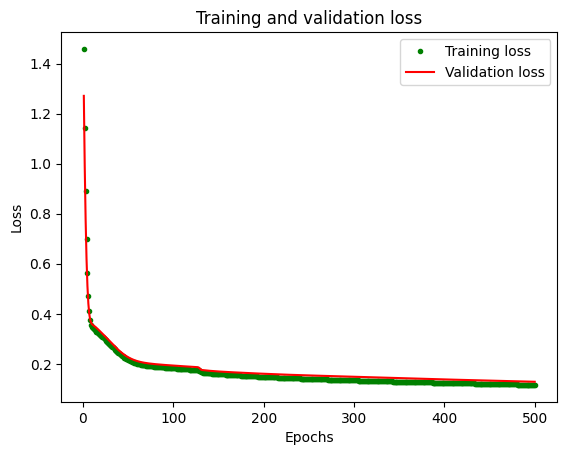

In [16]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_small.history['loss']
val_loss = history_small.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

To make the flatter part of the graph more readable, let's skip the first 50 epochs:

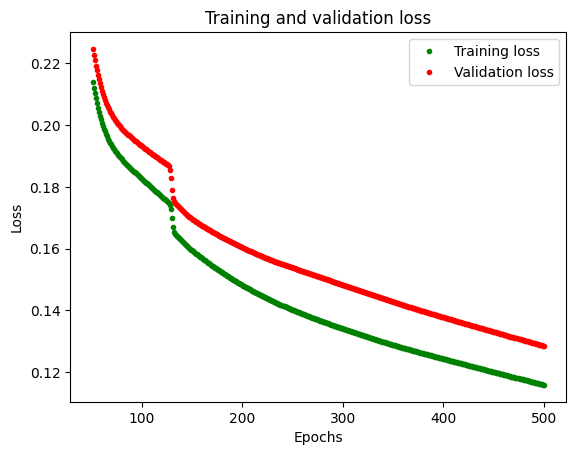

In [17]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, we can see that loss continues to reduce until around 200 epochs, at which point it is mostly stable. This means that there's no need to train our network beyond 200 epochs.

However, we can also see that the lowest loss value is still around 0.155. This means that our network's predictions are off by an average of ~15%. In addition, the validation loss values jump around a lot, and is sometimes even higher.

#### Mean Absolute Error

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:

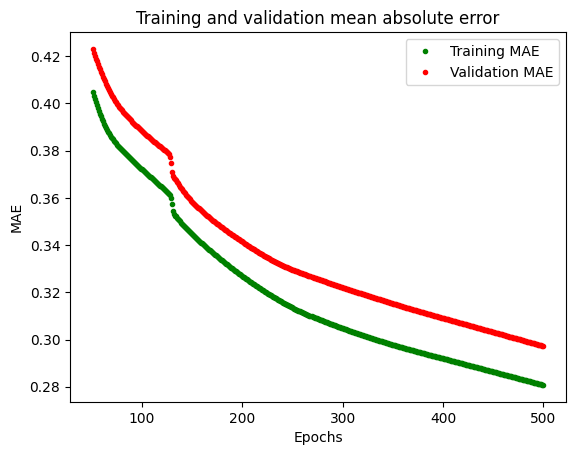

In [18]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_small.history['mae']
val_mae = history_small.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'r.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ tells another story. We can see that training data shows consistently lower error than validation data, which means that the network may have _overfit_, or learned the training data so rigidly that it can't make effective predictions about new data.

In addition, the mean absolute error values are quite high, ~0.305 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

#### Actual vs Predicted Outputs

To get more insight into what is happening, let's check its predictions against the test dataset we set aside earlier:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1071 - mae: 0.2676 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


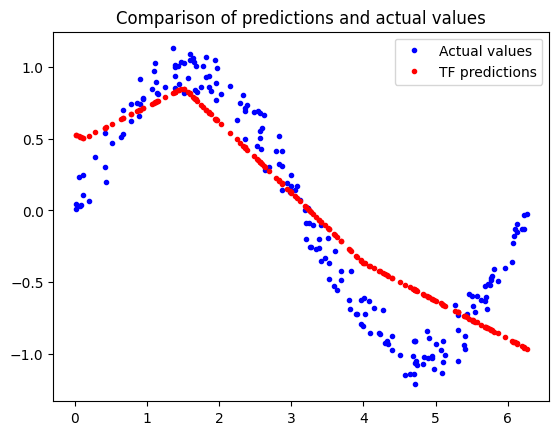

In [19]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_small.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_small.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way.

The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

## Training a Larger Model

### Design the Model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [23]:
model_large = keras.Sequential()

# Add an Input layer as the first layer
model_large.add(keras.Input(shape=(1,)))

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_large.add(keras.layers.Dense(16, activation='relu'))

# The new second and third layer will help the network learn more complex
# representations
model_large.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model_large.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared
# error or 'mse' loss function for regression.
model_large.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model_large.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model ###

We'll now train and save the new model.

In [24]:
# Train the model
history_large = model_large.fit(
    x_train, 
    y_train,
    epochs=500,  # Fewer epochs for a smaller model
    batch_size=64,
    validation_data=(x_validate, y_validate))

# Save the model
model_large.save(MODEL_KERAS)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7922 - mae: 0.7853 - val_loss: 0.6244 - val_mae: 0.7203
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5681 - mae: 0.6742 - val_loss: 0.5159 - val_mae: 0.6392
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4841 - mae: 0.6151 - val_loss: 0.4734 - val_mae: 0.5990
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4544 - mae: 0.5859 - val_loss: 0.4569 - val_mae: 0.5848
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4408 - mae: 0.5723 - val_loss: 0.4435 - val_mae: 0.5756
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4282 - mae: 0.5621 - val_loss: 0.4307 - val_mae: 0.5675
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4158 - mae: 0.5538 - val_loss: 0.4187 - val_mae: 0.5601
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4039 - mae: 0.5463 - val_loss: 0.4070 - val_mae: 0.5530
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

### Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ):

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0865
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

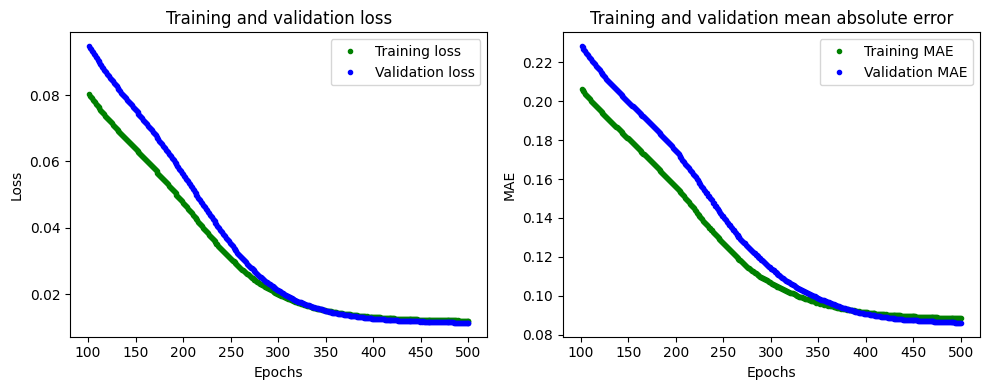

In [25]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_large.history['loss']
val_loss = history_large.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_large.history['mae']
val_mae = history_large.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Great results! From these graphs, we can see several exciting things:

*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - mae: 0.0871 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


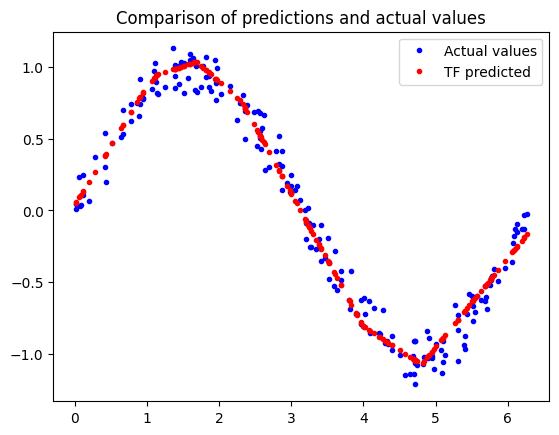

In [26]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_large.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_large.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.


### Generate Models with and without Quantization 
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

#### Convert the model to the TensorFlow Lite format without quantization

In [27]:
# Convert to float TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_large)
model_no_quant_tflite = converter.convert()

# Save the model to disk
with open(MODEL_NO_QUANT_TFLITE, "wb") as f:
    f.write(model_no_quant_tflite)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpd6avfqr_\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpd6avfqr_\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmpd6avfqr_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1727713706928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713707984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713736304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713737184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727712735824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713183696: TensorSpec(shape=(), dtype=tf.resource, name=None)


#### Convert the model to the TensorFlow Lite format with quantization


In [28]:
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])

# Set the optimization flag.
converter = tf.lite.TFLiteConverter.from_keras_model(model_large)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_int8_quant_tflite = converter.convert()

# Save the model to disk
with open(MODEL_INT8_QUANT_TFLITE, "wb") as f:
    f.write(model_int8_quant_tflite)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmposaojg6k\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmposaojg6k\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmposaojg6k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1727713706928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713707984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713736304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713737184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727712735824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727713183696: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

#### Helper functions

This code defines two functions for working with TensorFlow Lite (TFLite) models: **predict_tflite** and **evaluate_tflite**. 

- The predict_tflite function takes a TFLite model and test data, prepares the input, runs inference using the TFLite interpreter, and handles any necessary quantization or dequantization of inputs and outputs. 

- The evaluate_tflite function uses predict_tflite to generate predictions and then calculates the loss using the original model's loss function. These functions allow for efficient inference and evaluation of TFLite models, which are optimized versions of TensorFlow models designed for deployment on resource-constrained devices.

In [31]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])

  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = keras.losses.get(model_large.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

#### Predictions

Use the helper functions:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
C:\Users\user\AppData\Local\Temp\ipykernel_1746516\2557248112.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]


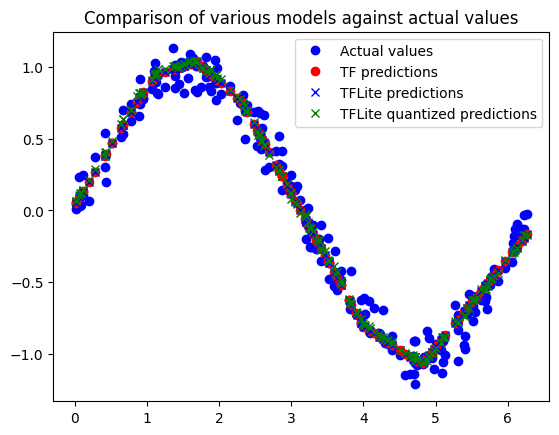

In [32]:
# Calculate predictions
y_test_pred_tf = model_large.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_int8_quant_tflite = predict_tflite(model_int8_quant_tflite, x_test)

# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_int8_quant_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

#### Loss (MSE/Mean Squared Error)

Mean Squared Error (MSE) is a widely used loss function in machine learning, particularly for regression tasks. It measures the average of the squared differences between predicted and actual value.

The formula is:
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2
$$

We can retrieve these values from the Keras framework. 

In [34]:
# Calculate loss
loss_tf, _ = model_large.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_int8_quant_tflite = evaluate_tflite(model_int8_quant_tflite, x_test, y_test)

# Compare loss
import pandas as pd

df = pd.DataFrame.from_records(
    [["TensorFlow / Keras", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_int8_quant_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
C:\Users\user\AppData\Local\Temp\ipykernel_1746516\2557248112.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]


,Loss/MSE
Model,
TensorFlow / Keras,0.0111
TensorFlow Lite,0.0111
TensorFlow Lite Quantized,0.0112


#### Size

Get the size of the binary files. 

In [35]:
# Calculate size
size_tf = os.path.getsize(MODEL_KERAS)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_int8_quant_tflite = os.path.getsize(MODEL_INT8_QUANT_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow / Keras", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_int8_quant_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_int8_quant_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow / Keras,29253 bytes,
TensorFlow Lite,3180 bytes,(reduced by 26073 bytes)
TensorFlow Lite Quantized,3424 bytes,(reduced by -244 bytes)


## Deploy model to the Firmware Project
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [36]:
import os
import re

def sanitize_name(name):
    """Convert filename to valid C variable name."""
    return re.sub(r'[^a-zA-Z0-9]+', '_', name)

def convert_to_c_source(input_file, output_file, bytes_per_line=12):
    """Convert binary file to C source array."""
    var_name = sanitize_name(os.path.basename(input_file))
    
    with open(input_file, 'rb') as f_in:
        content = f_in.read()
    
    with open(output_file, 'w') as f_out:
        f_out.write(f"const unsigned char {var_name}[] = {{\n  ")
        
        # Write bytes in hex format
        for i, byte in enumerate(content):
            if i > 0 and i % bytes_per_line == 0:
                f_out.write("\n  ")
            f_out.write(f"0x{byte:02x}, ")
        
        f_out.write(f"\n}};\n")
        f_out.write(f"const unsigned int {var_name}_len = {len(content)};\n")


convert_to_c_source(MODEL_NO_QUANT_TFLITE, MODEL_NO_QUANT_C)
convert_to_c_source(MODEL_INT8_QUANT_TFLITE, MODEL_INT8_QUANT_C)
    

## Convert to Ethos-U NPU model

Optionally convert the model for targets featuring the Ethos-U NPU. 

In [51]:
import site
 
# Get the site-packages path to find vela
site_packages_path = site.getsitepackages()[0]
print(site_packages_path)
 
# Construct the installation path of vela
if os.name == 'nt':
    velapath = r'C:\Users\user\AppData\Roaming\Python\Python39\Scripts\vela.exe'
 
# Convert the model to a Vela model
!{velapath} models/model_int8.tflite --output-dir models_vela --verbose-operators
 
convert_to_c_source ("models_vela/model_int8_vela.tflite", "models_vela/model_int8_vela.c")

c:\Program Files\Python39
Operators of Subgraph main
  0: FullyConnected - {'attribute_read_error': [], 'asymmetric_quantize_inputs': False, 'fused_activation_function': Relu, 'keep_num_dims': False, 'weights_format': 0, 'quantized_bias_type': 0} - sequential_4_1/dense_11_1/MatMul;sequential_4_1/dense_11_1/Relu;sequential_4_1/dense_11_1/BiasAdd
  1: FullyConnected - {'attribute_read_error': [], 'asymmetric_quantize_inputs': False, 'fused_activation_function': Relu, 'keep_num_dims': False, 'weights_format': 0, 'quantized_bias_type': 0} - sequential_4_1/dense_12_1/MatMul;sequential_4_1/dense_12_1/Relu;sequential_4_1/dense_12_1/BiasAdd
  2: FullyConnected - {'attribute_read_error': [], 'asymmetric_quantize_inputs': False, 'fused_activation_function': None, 'keep_num_dims': False, 'weights_format': 0, 'quantized_bias_type': 0} - StatefulPartitionedCall_1:0

Network summary for model_int8
Accelerator configuration               Ethos_U55_256
System configuration             Ethos_U55_High_E

In [ ]:
#Display the models_vela/model_int8_summary_Ethos_U55_High_End_Embedded.csv convertion metrics
df = pd.read_csv("models_vela/model_int8_summary_Ethos_U55_High_End_Embedded.csv")
df

## Deploy to a Microcontroller

Within this project, the model is copied into the Model layer in [`Model`] after the Jupyter Notebook executed successful. There is will be used by hello_world_test.cpp. 

In [52]:
import shutil
# Copy model_int8.c to ../Model/ directory
shutil.copy('models/model_int8.c', '../Model/')

# Copy model_float.c to ../Model/ directory
shutil.copy('models/model_float.c', '../Model/')

# Copy model_int8_vela.c to ../Model/ directory
shutil.copy('models_vela/model_int8_vela.c', '../Model/')


'../Model/model_int8_vela.c'